In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def solve_by_thomas_algorithm(a, b, c, d):
    """
    Solve a tridiagonal system A x = d using the Thomas algorithm.

    Parameters
    ----------
    a, b, c : 1D numpy arrays
        Vectors for the sub-diagonal (a), main diagonal (b), and super-diagonal (c).
    d : 1D numpy array
        Right-hand side vector.

    Returns
    -------
    x : 1D numpy array
        Solution of the tridiagonal system A x = d.
    """
    N = len(b)
    cp = np.zeros(N)  # 'c prime'
    dp = np.zeros(N)  # 'd prime'
    x  = np.zeros(N)

    # Forward sweep
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, N):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom

    # Back substitution
    x[-1] = dp[-1]
    for i in range(N - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]

    return x

def solve_heat_equation(params):
    """
    Solve the 1D heat equation using the Crank–Nicolson method with a Thomas algorithm.

    Parameters
    ----------
    params : tuple
        (alpha, L, Nx, Nt, dt, u_boundary, u_ini, r)

        alpha      : Thermal diffusivity
        L          : Length of the domain
        Nx         : Number of spatial grid points
        Nt         : Number of time steps
        dt         : Time step size
        u_boundary : tuple (u_left, u_right) for Dirichlet boundary conditions
        u_ini      : 1D numpy array (length Nx) for the initial temperature profile
        r          : alpha * dt / (dx^2)

    Returns
    -------
    ts : 1D numpy array of time values, length Nt
    solutions : 2D numpy array of shape (Nx, Nt+1)
        solutions[:, k] is the numerical solution at time step k,
        with k=0 storing the initial condition.
    """

    alpha, L, Nx, Nt, dt, u_boundary, u_ini, r = params

    # Copy the initial condition so we don't overwrite it
    u = u_ini.copy()

    # Create an array to store the solutions for each time step
    # We store time steps 0 through Nt (inclusive), so shape is (Nx, Nt+1).
    solutions = np.zeros((Nx, Nt+1))
    # Store the initial profile in the first column
    solutions[:, 0] = u

    # Time array: times at which we have solutions
    ts = np.arange(0, Nt*dt, dt)

    # Time-stepping loop
    for n in range(Nt):
        # Build right-hand side vector d
        d = np.zeros(Nx)
        for i in range(Nx):
            # (1 - r)*u[i]
            d[i] = (1 - r) * u[i]
            if i > 0:
                d[i] += (r/2) * u[i - 1]
            if i < Nx - 1:
                d[i] += (r/2) * u[i + 1]

        # Incorporate Dirichlet boundaries into the RHS
        d[0]     += r * u_boundary[0]
        d[-1]    += r * u_boundary[1]

        # Build the tridiagonal coefficients for the LHS
        a = np.zeros(Nx)
        b = np.zeros(Nx)
        c = np.zeros(Nx)

        b[:] = 1 + r  # main diagonal
        for i in range(1, Nx):
            a[i] = -r / 2.0  # sub-diagonal
        for i in range(Nx - 1):
            c[i] = -r / 2.0  # super-diagonal

        # Solve the tridiagonal system
        u_new = solve_by_thomas_algorithm(a, b, c, d)

        # Enforce the boundary values directly (Dirichlet)
        u_new[0]  = u_boundary[0]
        u_new[-1] = u_boundary[1]

        # Update u for the next iteration
        u = u_new
        # Store the solution at this time step
        solutions[:, n+1] = u

    return ts, solutions


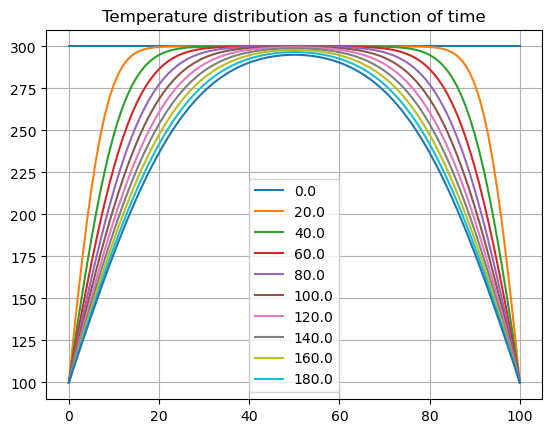

In [3]:
α = 1.0e-4    
L = 1.0
Nx = 101
Nt = 2000
Δt = 0.1
σ = 0.05
u_boundary = (100.0,100.0)

Δx = L/(Nx-1)
r = α*Δt/(Δx*Δx)

xs = np.linspace(0.0, L, Nx)

# Initial condition: Gaussian bump over 300 K

u_ini = 300 * np.ones(Nx)

# Pack parameters
params = α, L, Nx, Nt, Δt, u_boundary, u_ini, r

# Final run
ts, solutions = solve_heat_equation(params);

# Plot
plt.plot(solutions[:,::200]);
plt.legend(ts[::200])
plt.title("Temperature distribution as a function of time")
plt.grid()

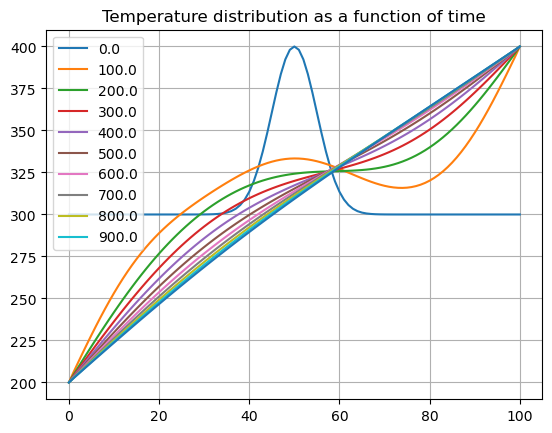

In [4]:
α = 1.0e-4    
L = 1.0
Nx = 101
Nt = 10000
Δt = 0.1
σ = 0.05
u_boundary = (200.0,400.0)

Δx = L/(Nx-1)
r = α*Δt/(Δx*Δx)

xs = np.linspace(0.0, L, Nx)

# Initial condition: Gaussian bump over 300 K

u_ini = 300.0 + 100*np.exp(-(xs - L/2)**2/2/σ**2)  

# Pack parameters
params = α, L, Nx, Nt, Δt, u_boundary, u_ini, r

# Final run
ts, solutions = solve_heat_equation(params);

# Plot
plt.plot(solutions[:,::1000]);plt.legend(ts[::1000])
plt.title("Temperature distribution as a function of time")
plt.grid()